In [9]:
from openai import OpenAI
import base64
client = OpenAI(base_url="http://localhost:8000/v1", api_key="llama.cpp")

def image_to_base64_data_uri(file_path):
    with open(file_path, "rb") as img_file:
        base64_data = base64.b64encode(img_file.read()).decode('utf-8')
        return f"data:image/png;base64,{base64_data}"

image_path = "./example/test.jpg"  
data_uri = image_to_base64_data_uri(image_path)

messages = [
    {"role": "system", "content": "You are an assistant who perfectly describes images."},
    {
        "role": "user",
        "content": [
            {"type": "image_url", "image_url": {"url": data_uri }},
            {"type" : "text", "text": "Describe this image in detail please."}
        ]
    }
]
response = client.chat.completions.create(
    model="local-model",
    messages=messages,
    temperature=0.7,
    max_tokens=500
)

response.choices[0].message.content

APIConnectionError: Connection error.

In [25]:
from PIL import Image
from lang_sam import LangSAM

model = LangSAM()
image_path = "./example/test.jpg"
image_pil = Image.open(image_path).convert("RGB")
text_prompt = "Detect and segment the natural creases and lines present on the hand's surface"
results = model.predict([image_pil], [text_prompt])

Predicting 1 masks
Predicted 1 masks


/opt/tljh/user/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Image loaded successfully.


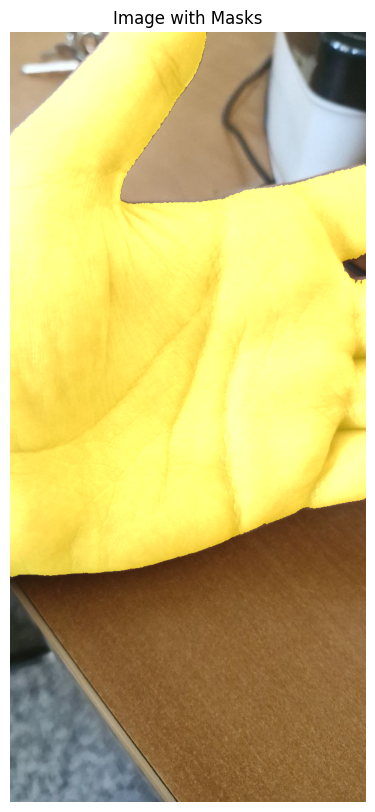

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'image_path' is defined
image = cv2.imread(image_path)

# Check if image was loaded
if image is None:
    print(f"Failed to load image at {image_path}")
else:
    print(f"Image loaded successfully.")

# Convert BGR (OpenCV default) to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a copy of the image to draw masks on
overlay = image.copy()

# Define colors for masks (adjust or add more colors if you have more masks)
colors = [
    (255, 0, 0),     # Red for the first mask
    (0, 255, 0),     # Green for the second mask
    # Add more colors if needed
]

alpha = 0.5

# Check if 'results' structure is correct
if not isinstance(results, list) or not isinstance(results[0], dict):
    print("Invalid 'results' structure.")
    exit()

# Ensure 'results[0]['masks']' exists
if 'masks' not in results[0]:
    print("No 'masks' key in results[0].")
    exit()

# Iterate over each mask
for idx, mask in enumerate(results[0]['masks']):
    # Ensure mask is a binary mask (values 0 or 1)
    mask = mask.astype(np.uint8)
    
    # Optionally threshold the mask if it's not already binary
    # _, mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)

    # Create a colored version of the mask
    colored_mask = np.zeros_like(image)
    for c in range(3):  # For each color channel
        colored_mask[:, :, c] = mask * colors[idx % len(colors)][c]

    # Blend the colored mask with the image
    overlay = cv2.addWeighted(overlay, 1, colored_mask.astype(np.uint8), alpha, 0)

# Display the image with masks overlaid
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis('off')
plt.title('Image with Masks')
plt.show()

In [18]:
np.all(results[0]["masks"]) == 0 

np.True_

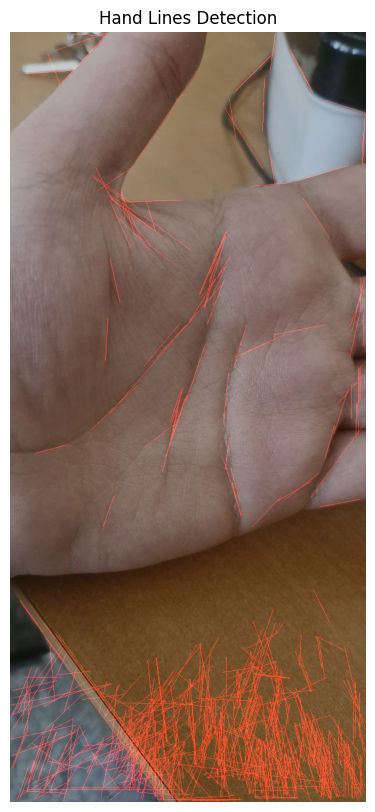

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
original = cv2.imread(image_path)

# Convert to grayscale
img = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization
img = cv2.equalizeHist(img)

# Apply Gaussian blur
img = cv2.GaussianBlur(img, (9, 9), 0)

# Apply Canny edge detection
img = cv2.Canny(img, 40, 80)

# Create blank image for lines
lined = np.copy(original) * 0

# Apply Hough Lines transformation
lines = cv2.HoughLinesP(img, 1, np.pi / 180, 15, np.array([]), 50, 20)

# Draw the lines
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(lined, (x1, y1), (x2, y2), (0, 0, 255))

# Combine original image with lines
output = cv2.addWeighted(original, 0.8, lined, 1, 0)

# Convert BGR to RGB for matplotlib display
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# Display the final result
plt.figure(figsize=(10, 10))
plt.imshow(output_rgb)
plt.axis('off')
plt.title('Hand Lines Detection')
plt.show()